Spustenie IPD evolučného algoritmu.
Počet protihráčov: 4
Veľkosť populácie: 300
Maximálny počet generácií: 150
gen	nevals	avg    	min   	max   
0  	300   	217.762	182.25	270.75
1  	263   	232.334	175.75	271.5 
2  	257   	241.978	186.5 	278.5 
3  	247   	251.667	209.5 	283.25
4  	269   	260.266	206   	285.25
5  	248   	265.003	217   	287   
6  	242   	267.611	215.5 	287.75
7  	255   	269.28 	186   	287.75
8  	263   	271.999	218.75	286.75
9  	258   	272.896	178.5 	291.25
10 	264   	274.254	210.25	294.25
11 	239   	273.57 	207.75	289.25
12 	244   	274.612	210.5 	290   
13 	256   	275.603	217   	289.25
14 	245   	275.605	205.75	294.75
15 	248   	275.122	210   	294.75
16 	249   	276.383	219.5 	291.5 
17 	249   	275.918	229.25	292.75
18 	255   	275.752	217   	291   
19 	248   	274.332	227.75	291.5 
20 	250   	274.692	217.25	293.5 
21 	250   	274.591	188.25	289.75
22 	254   	274.707	213.25	290.5 
23 	252   	273.685	214.75	291.75
24 	253   	274.708	210.5 	289.5 
25 	246   	275.223	214   	289.5

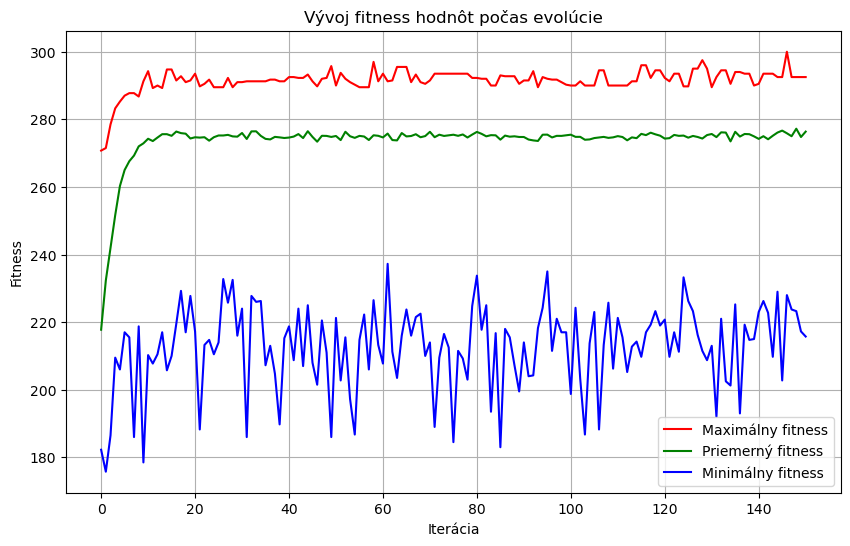

In [5]:
#!pip install deap matplotlib

import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# ======================================================================================
# konfiguracia hry
# ======================================================================================
HISTORY_LENGTH = 2           # pocet predoslych tahov ktore brat na ohlad
GENOME_LENGTH = 2**(2*HISTORY_LENGTH) # pre spravne vyuzitie genomu v tabulke
NUM_ROUNDS = 100             # pocet kol na jednu hru

# ======================================================================================
# parametre genetickeho algoritmu
# ======================================================================================
POPULATION_SIZE = 300        # pocet individualov v populacii
MUTATION_RATE = 0.2          # sanca mutacie
CROSSOVER_RATE = 0.8         # sanca krizenia
TOURNAMENT_SIZE = 4          # pocet jedincov v turnaji
ELITISM_SIZE = 5             # pocet elitnych jedincov
MAX_GENERATIONS = 150        # pocet generacii

# hodnoty pre geny (0 = spolupraca, 1 = zrada)
MIN_STRATEGY_VALUE = 0
MAX_STRATEGY_VALUE = 1

# ======================================================================================
# protihraci (False ak nechceme)
# ======================================================================================
ALWAYSCOOPERATE = True
ALWAYSDEFECT = True
TITFORTAT = True
RANDOM = True

# ======================================================================================
# tabulka iterovaneho vaznovho dilema
# ======================================================================================
IPDTABLE = {
    (0, 0): (3, 3),  # obaja spolupracuju
    (0, 1): (0, 5),  # agent spolupracuje, oponent zradi
    (1, 0): (5, 0),  # agent zradi, oponent spolupracuje
    (1, 1): (1, 1)   # obaja zradia
}

# ======================================================================================
# strategie superov
# ======================================================================================

def always_cooperate(history=None):
    # vzdy spolupracovat
    return 0

def always_defect(history=None):
    # vzdy zradit
    return 1

def tit_for_tat(opp_hist):
    # spolupracovat na zaciatku potom kopirovat
    return opp_hist[-1] if opp_hist else 0

def random_strategy(history=None):
    # nahoda
    return random.randint(0, 1)

# ======================================================================================
# inicializacia zoznamu oponentov podla vybranych strategii
# ======================================================================================
OPPONENTS = []

if ALWAYSCOOPERATE:
    OPPONENTS.append(("Always Cooperate", always_cooperate))
if ALWAYSDEFECT:
    OPPONENTS.append(("Always Defect", always_defect))
if TITFORTAT:
    OPPONENTS.append(("Tit for Tat", tit_for_tat))
if RANDOM:
    OPPONENTS.append(("Random", random_strategy))

# ======================================================================================
# funkcie pre geneticky algoritmus
# ======================================================================================

def decode_strategy(genome, agent_history, opponent_history):
    # vrati rozhodnutie na zaklade genomu a historie tahov
    if len(agent_history) < HISTORY_LENGTH or len(opponent_history) < HISTORY_LENGTH:
        return 0  # ak nie je dostatok historie, spolupracujeme
    
    # ziskanie poslednych tahov z historie
    recent_agent_moves = agent_history[-HISTORY_LENGTH:]
    #print(f"recent moves: {recent_agent_moves}")
    recent_opponent_moves = opponent_history[-HISTORY_LENGTH:]
    
    # vytvorenie indexu do genomu na zaklade historie
    genome_index = 0
    
    # postupne vytvarame index z historie oboch hracov napr:
    # pre HISTORY_LENGTH=2 vytvorime index v rozpati 0-15
    # reprezentujuci vsetky mozne kombinacie 4 bitov historie
    # napr. [agent=0,oponent=1,agent=1,oponent=0] = index 6
    # v skutku na toto by som sam asi nikdy nedosiel ale cital som https://www.jessiefin.com/assets/pdf/tog-coop-ipd.pdf
    for i in range(HISTORY_LENGTH):
        # posun dolava pre miesto na dalsi bit
        genome_index = genome_index << 1
        # pridanie tahu agenta ako dalsi bit
        genome_index = genome_index | recent_agent_moves[i]
        
        # dalsi posun dolava
        genome_index = genome_index << 1
        # pridanie tahu oponenta ako dalsi bit
        genome_index = genome_index | recent_opponent_moves[i]
    
    # vrat zakodovane rozhodnutie z genomu
    # genom obsahuje 0 alebo 1 pre kazdu moznu kombinaciu historie
    # tieto hodnoty sa evolvuju genetickym algoritmom
    return genome[genome_index]

def play_game(genome, opponent_strategy, num_rounds=NUM_ROUNDS):
    # spusti hru a vrati skore agenta
    agent_hist = []
    opp_hist = []
    agent_score = 0
    
    for _ in range(num_rounds):
        # agent cini podla genomu a historie 
        agent_move = decode_strategy(genome, agent_hist, opp_hist)
        
        # ocakava to tit-for-tat podla toho co robil predtym agent
        opp_move = opponent_strategy(agent_hist)
        
        agent_hist.append(agent_move)
        opp_hist.append(opp_move)
        
        # vyhodnotenie kola
        agent_reward, _ = IPDTABLE[(agent_move, opp_move)]
        agent_score += agent_reward
    
    return agent_score

def evaluate_fitness(genome):
    # vyhodnoti fitness genomu
    total_score = 0
    
    # docasne nastavit globalnu premennu
    global BEST_GENOME
    original_genome = BEST_GENOME
    BEST_GENOME = genome
    
    # prechadzame vsetky strategie a superov a vyhodnocujeme ich
    # tym ze spustame hru s genomom
    for _, opponent_strategy in OPPONENTS:
        game_score = play_game(genome, opponent_strategy)
        if game_score > 0:
            total_score += game_score

    # vratit spiatocne globalnu premennu
    BEST_GENOME = original_genome
    
    # vystup je priemerne skore
    average_score = total_score / len(OPPONENTS)
    return (average_score,)

# ======================================================================================
# vymaz existujuce triedy deap aby neboli chyby
# ======================================================================================
if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax
if "Individual" in creator.__dict__:
    del creator.Individual

# ======================================================================================
# inicializacia deap toolboxu
# ======================================================================================

# vytvorenie classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)


toolbox = base.Toolbox()

# registracia funkcii do toolboxu
toolbox.register("gene_maker", random.randint, MIN_STRATEGY_VALUE, MAX_STRATEGY_VALUE)
toolbox.register("individual_creator", tools.initRepeat, creator.Individual, 
                 toolbox.gene_maker, n=GENOME_LENGTH)
toolbox.register("population_creator", tools.initRepeat, list, toolbox.individual_creator)

# operatory gen. algoritmu
toolbox.register("evaluate", evaluate_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=MIN_STRATEGY_VALUE, up=MAX_STRATEGY_VALUE, 
                 indpb=MUTATION_RATE)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

# statistiky
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)  # avg fitness
stats.register("min", np.min)   # min fitness
stats.register("max", np.max)   # max fitness

# ======================================================================================
# implementacia funkcie zrada na zaklade vyevolvovaneho genomu
# ======================================================================================

# globalna premenna pre ulozenie najlepsieho genomu
BEST_GENOME = None

def zrada(moja_historia, protihracova_historia):
    # vracia nasledujuci tah (0 = spolupraca, 1 = zrada) 
    # na zaklade historie vlastnych tahov a tahov protihraca

    global BEST_GENOME
    
    # ak nemame najlepsi genom, vratime defaultne 0 (spolupraca)
    if BEST_GENOME is None:
        return 0
    
    #print(f"Najlepsi genom nacitany v zrade: {BEST_GENOME}")
    
    # dependentna na decode_strategy
    return decode_strategy(BEST_GENOME, moja_historia, protihracova_historia)

# ======================================================================================
# hlavny program
# ======================================================================================

def interpret_strategy(best_genome):
  
    # Interpretácia najlepšej stratégie agenta na základe histórie.

    print("\nInterpretácia najlepšej stratégie:")
    print("-" * 55)
    print(f"{'História agenta':<20} {'História oponenta':<20} {'Ďalší krok agenta':<15}")
    print("-" * 55)

    for i, decision in enumerate(best_genome):
        # Prevedieme index na binárnu reprezentáciu histórie
        binary = format(i, f'0{2 * HISTORY_LENGTH}b')
        agent_hist = binary[::2]  # História agenta (každý druhý bit)
        opp_hist = binary[1::2]   # História oponenta (každý druhý bit)

        # Preložíme históriu do čitateľnej podoby
        agent_hist_str = ''.join(['Spol. ' if bit == '0' else 'Zrada ' for bit in agent_hist])
        opp_hist_str = ''.join(['Spol. ' if bit == '0' else 'Zrada ' for bit in opp_hist])

        # Rozhodnutie agenta
        action = "Spolupráca" if decision == 0 else "Zrada"

        # Výpis interpretácie v tabuľkovom formáte
        print(f"{agent_hist_str:<20} {opp_hist_str:<20} {action:<15}")

def plot_evolution(logs):
    # vykreslenie grafu vyvoja fitness hodnot
    gen = logs.select("gen")
    fit_avg = logs.select("avg")
    fit_min = logs.select("min")
    fit_max = logs.select("max")
    
    plt.figure(figsize=(10, 6))
    plt.plot(gen, fit_max, "r-", label="Maximálny fitness")
    plt.plot(gen, fit_avg, "g-", label="Priemerný fitness")
    plt.plot(gen, fit_min, "b-", label="Minimálny fitness")
    plt.title("Vývoj fitness hodnôt počas evolúcie")
    plt.xlabel("Iterácia")
    plt.ylabel("Fitness")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

def print_v_zrade(moja_h, protihrac_h, result):
     print(f"História agenta: {moja_h}, História oponenta: {protihrac_h} -> ďalší krok: {result}")

def test_funkcie_zrada():
    # testovanie implementacie funkcie zrada
    print("\nTest funkcie zrada():")
    print("-" * 55)
    print("0 = spolupráca, 1 = zrada")

    # ====================================
    # test s prazdnou historiou
    # ====================================
    print("Test s prázdnou históriou:")
    moja_hist = []
    protihrac_hist = []
    result = zrada(moja_hist, protihrac_hist)
    print_v_zrade(moja_hist, protihrac_hist, result)

    # ====================================
    # test s malou historiou
    # ====================================
    print("\nTest s malou históriou:")
    moja_hist = [0, 1]  # spolupraca, zrada
    protihrac_hist = [0, 0]  # spolupraca, spolupraca
    result = zrada(moja_hist, protihrac_hist)
    print_v_zrade(moja_hist, protihrac_hist, result)
    
    # ====================================
    # test s titfortat historiou 
    # ====================================
    print("\nTest s tit-for-tat históriou:")
    moja_hist =      [0, 0, 1, 0, 1, 0]
    protihrac_hist = [0, 0, 0, 1, 0, 1]
    result = zrada(moja_hist, protihrac_hist)
    print_v_zrade(moja_hist, protihrac_hist, result)

    # ====================================
    # test s random historiou 
    # ====================================
    print("\nTest s random históriou:")
    moja_hist =      [0, 0, 1, 0, 1, 0]
    protihrac_hist = [random.choice([0, 1]) for _ in moja_hist]
    result = zrada(moja_hist, protihrac_hist)
    print_v_zrade(moja_hist, protihrac_hist, result)

    # ====================================
    # test s always cooperate historiou 
    # ====================================
    print("\nTest s always cooperate históriou:")
    moja_hist =      [0, 1, 1, 1, 1, 1]
    protihrac_hist = [0, 0, 0, 0, 0, 0]
    result = zrada(moja_hist, protihrac_hist)
    print_v_zrade(moja_hist, protihrac_hist, result)

    # ====================================
    # test s always defect historiou 
    # ====================================
    print("\nTest s always defect históriou:")
    moja_hist =      [0, 1, 1, 1, 1, 1]
    protihrac_hist = [0, 1, 1, 1, 1, 1]
    result = zrada(moja_hist, protihrac_hist)
    print_v_zrade(moja_hist, protihrac_hist, result)



if __name__ == "__main__":
    print("Spustenie IPD evolučného algoritmu.")
    print(f"Počet protihráčov: {len(OPPONENTS)}")
    print(f"Veľkosť populácie: {POPULATION_SIZE}")
    print(f"Maximálny počet generácií: {MAX_GENERATIONS}")
    
    # vytvorenie pociatocnej populacie
    population = toolbox.population_creator(n=POPULATION_SIZE)
    
    # inicializacia hof (hall of fame) pre sledovanie najlepsich jedincov
    hof = tools.HallOfFame(ELITISM_SIZE)
    
    # inicializacia logbook pre zaznamenavanie statistik
    logs = tools.Logbook()
    
    # spustenie genetickeho algoritmu
    population, logs = algorithms.eaSimple(
        population, 
        toolbox,
        cxpb=CROSSOVER_RATE,
        mutpb=MUTATION_RATE,
        ngen=MAX_GENERATIONS,
        stats=stats,
        halloffame=hof,
        verbose=True
    )
    
    # top hof = best genome
    best_genome = hof[0]
    print("Najlepší genóm:", best_genome)
    print("Fitness hodnota:", best_genome.fitness.values[0])
     
    # ulozenie najlepsieho genomu pre funkciu zrada
    BEST_GENOME = best_genome
    
    # interpretacia 
    interpret_strategy(best_genome)
    
    # test funkcie zrada resp. test najlepsej strategie
    test_funkcie_zrada()

    # vykreslenie grafu
    plot_evolution(logs)